# Offline learning with a loan pricing example

We'll look into off-line learning. "offline data" means that we have historical actions and rewards that were generated with a different policy. This policy might have been a random policy, a suboptimal policy or sometimes even an unknown one.

While learning from off-line data can be more challenging, it can be a good way to give your contextual bandit a warm start.

## Loan pricing example

Your task is to learn the best interest rate to offer to a customer.
There are three main components to your profits

+ Conversion rate: the probability that a customer will convert to a loan
+ Cost of risk (CoR): the cost of the risk of defaulting on the loan
+ Revenue: total income generated from the customer. This includes the amount of the loan, fees, etc.

This is a simplification, but we can write the expected profit as

$$ p(conversion) * ( revenue - CoR ) $$

In principle, the interest rate affects all three components, but in this example we'll only consider its effect on the conversion rate and cost of risk. In the `oracle` class below, you can see that each arm (interest rate) has a different effect on the conversion rate and a different cost of risk.

The context are the features of the loan and the customer. The task of the contextual bandit is to learn the best interest rate to offer to each context.

+ *Context*: In this example, we use a single feature: the age of the customer. (*we'll use a strange scaling for the age, from -5 to 5, but pretend it's a rescaling of years*)
+ *Actions / arms*: We have two actions (interest rates) to choose from: 10% and 15%



In [1]:
import numpy as np
from numpy.typing import NDArray
from scipy.special import expit
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')


class LoanOracle:
    def __init__(self):
        self.context = None
        self.rewards = [] 
        self.optimal_rewards = [] 
        self.expected_rewards = []  # p of the article chosen for the given context

        self.true_coefs = np.array(
            [
                [1, 0.2],
                [1, 0.15]
            ]
        )
        self.cost_of_risk = np.array([0.5, 0.3])
        
        # Action 1 (interest rate 10%) doesn't have any effect on conversion rate
        # Action 2 (interest rate 15%) reduces conversion rate by 0.5
        self.conv_effect_of_interest_rate = np.array([0, -0.5])

    def set_context(self, context: NDArray[np.float64]):

        self.context = context

    def generate_reward(self, _coef: NDArray[np.float64], _cost_of_risk: float,
            _conv_effect_of_interest_rate: float) -> int:
        assert self.context is not None

        #Probability of conversion
        p_conversion = expit(np.dot(self.context, _coef) + _conv_effect_of_interest_rate)
        conversion = np.random.binomial(1, p_conversion)

        reward = conversion * (np.dot(self.context, _coef) - _cost_of_risk)
        expected_reward = p_conversion * (np.dot(self.context, _coef) - _cost_of_risk)
        self.rewards.append(reward)
        self.expected_rewards.append(expected_reward)
        return reward

    def best_expected_reward(self):
        assert self.context is not None

        p_conversions = expit(np.dot(self.context, self.true_coefs.T) + self.conv_effect_of_interest_rate)
        expected_rewards = p_conversions * (np.dot(self.context, self.true_coefs.T) - self.cost_of_risk)
        self.optimal_rewards.append(
            np.max(expected_rewards)
        )

    def interest_rate_10(self):
        """
        10% interest rate
        Works well for contexts where age is below ~1.3
        """
        return self.generate_reward(self.true_coefs[0], self.cost_of_risk[0], self.conv_effect_of_interest_rate[0])

    def interest_rate_15(self):
        """
        15% interest rate
        Works well for contexts where age is above ~2
        """
        return self.generate_reward(self.true_coefs[1], self.cost_of_risk[1], self.conv_effect_of_interest_rate[1])



### Visualizing the context and optimal action / arm

We'll construct the expected rewards for both actions over the context space (age of the customer from -5 to 5)

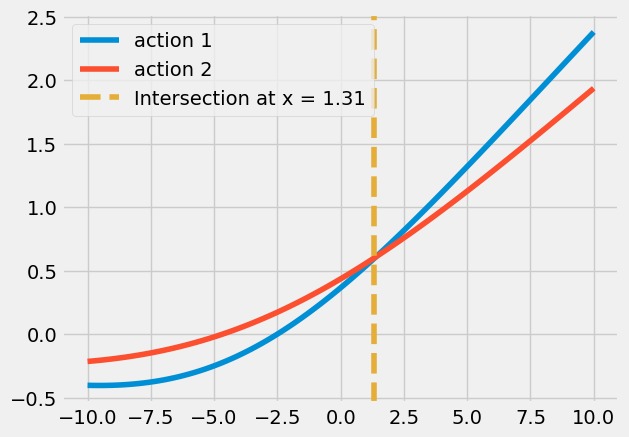

In [2]:
expected_rewards_for_action_1 = []
expected_rewards_for_action_2 = []
ages = np.linspace(-10, 10, 100)
oracle = LoanOracle()

for age in ages:

    context = np.array([1.0, age])

    p_conversion_1 = expit(np.dot(context, oracle.true_coefs[0]) 
                           + oracle.conv_effect_of_interest_rate[0])
    expected_reward_1 = p_conversion_1 * (np.dot(context, oracle.true_coefs[0]) 
                                          - oracle.cost_of_risk[0])
    expected_rewards_for_action_1.append(expected_reward_1)


    p_conversion_2 = expit(np.dot(context, oracle.true_coefs[1]) 
                           + oracle.conv_effect_of_interest_rate[1])
    expected_reward_2 = p_conversion_2 * (np.dot(context, oracle.true_coefs[1]) 
                                          - oracle.cost_of_risk[1])
    expected_rewards_for_action_2.append(expected_reward_2)

#Find intersection point where action 1 becomes better than action 2
diff = np.array(expected_rewards_for_action_1) - np.array(expected_rewards_for_action_2)
intersection_idx = np.where(np.diff(np.signbit(diff)))[0][0]

action_intersect = float(ages[intersection_idx])

plt.plot(ages, expected_rewards_for_action_1, label="action 1")
plt.plot(ages, expected_rewards_for_action_2, label="action 2")

plt.axvline(x=action_intersect, linestyle='--', color='#e5ae38', label=f"Intersection at x = {action_intersect:.2f}")
plt.legend()



In [3]:
from enum import Enum

class InterestRate(Enum):
    interest_rate_10 = 1
    interest_rate_15 = 2

    def take_action(self, oracle: LoanOracle):
        if self == InterestRate.interest_rate_10:
            return oracle.interest_rate_10()
        elif self == InterestRate.interest_rate_15:
            return oracle.interest_rate_15()
        else:
            raise ValueError("invalid param")


### Using online data

First we'll use online data (i.e., we will start with a weak prior and learn / update while we are taking actions).

We set up a `ContextualAgent` with a `UpperConfidenceBound` policy and a `NormalInverseGammaRegressor` learner and two arms.


In the simulation, besides the regret, we'll also record the context and the actions taken to plot them later.

Where does `true_reward_mean = 0.45`come from? It's better if the reward update is centered in 0 because of how `NormalInverseGammaRegressor()` builds its prior. In real life, we wouldn't know what this true reward mean is in advance, but we can simulate and get a number that is at least within the right scale.


In [4]:
from bayesianbandits import (
    Arm,
    NormalInverseGammaRegressor,
    ContextualAgent,
    UpperConfidenceBound
)

arms = [
    Arm(InterestRate.interest_rate_10, learner=NormalInverseGammaRegressor()),
    Arm(InterestRate.interest_rate_15, learner=NormalInverseGammaRegressor()),
]

agent = ContextualAgent(
    arms=arms,
    policy=UpperConfidenceBound(0.96),
)

# Simulation starts
####################

oracle = LoanOracle()

np.random.seed(111)
true_reward_mean = 0.45

user_ages = []
actions = []

for _ in range(3000):

    #Make user_age a float between -5 and 5
    user_age = np.random.uniform(-5, 5) 

    context = np.array([1.0, user_age])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    agent.update(context, oracle.rewards[-1] - true_reward_mean)

    user_ages.append(user_age)
    actions.append(action.name)




While not quite sublinear, the cumulative regret looks fine. Bear in mind that we are approximating a highly non-linear function (the true data generating process of the expected reward) with a linear one (the linear model that LinUCB uses through our `NormalInverseGammaRegressor` learners).

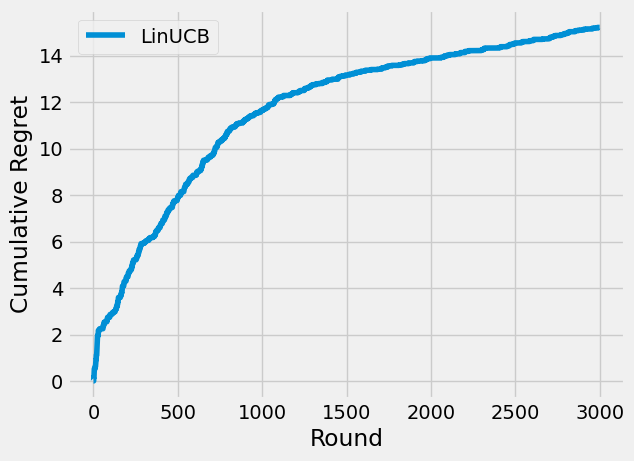

In [5]:
linucb_regret = np.cumsum(
    np.array(oracle.optimal_rewards) - np.array(oracle.expected_rewards)
)
linucb_regret_at_1000 = linucb_regret[1000]
plt.plot(linucb_regret, label="LinUCB")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

plt.legend()

Above, we found an intersection where the interest rate 10% becomes better than the 15% interest rate. If the bandit learnt correctly, we should see this interest rate more often after the intersection.

The plot below shows this is the case.


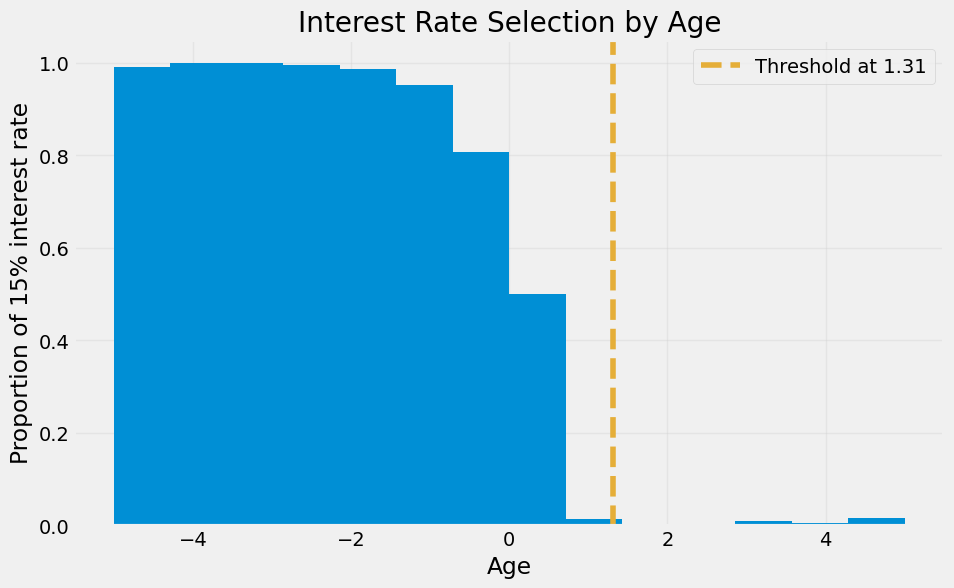

In [6]:
action_binary = np.array([1 if a == 'interest_rate_15' else 0 for a in actions])

bin_edges = np.linspace(-5, 5, 15)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate proportion of 1s for each bin
proportions = []
for i in range(len(bin_edges) - 1):
    mask = (user_ages >= bin_edges[i]) & (user_ages < bin_edges[i+1])
    bin_values = action_binary[mask]
    proportion = np.mean(bin_values) if len(bin_values) > 0 else 0
    proportions.append(proportion)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, proportions, width=np.diff(bin_edges)[0])
plt.axvline(x=action_intersect, linestyle='--', color='#e5ae38', 
            label=f'Threshold at {action_intersect:.2f}')
plt.xlabel('Age')
plt.ylabel('Proportion of 15% interest rate')
plt.title('Interest Rate Selection by Age')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Offline learning

We'll first simulate offline data. We'll use a random uniform policy which shouldn't give us bias. For a different policy, if you want an unbiased estimate, you should use some technique that corrects it, such as inverse propensity scoring, doubly robust estimation, etc.

We will save the actions and contexts. We can get the rewards later from the oracle. There won't be any agent updates, since we're not doing online learning.

In [7]:
oracle = LoanOracle()

np.random.seed(111)

contexts = []
actions = []

for _ in range(3000):

    user_age = np.random.uniform(-5, 5) 

    context = np.array([1.0, user_age])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action = InterestRate(np.random.randint(1, 3))
    action.take_action(oracle)

    contexts.append(context)
    actions.append(action)

Now that we have the rewards, contexts and actions, we can update our agent offline. We'll use a decay rate of 0.95 to ensure that the learners don't converge too quickly and keep learning when the online data starts.

In [8]:
arms = [
    Arm(InterestRate.interest_rate_10, learner=NormalInverseGammaRegressor()),
    Arm(InterestRate.interest_rate_15, learner=NormalInverseGammaRegressor()),
]

offline_agent = ContextualAgent(
    arms=arms,
    policy=UpperConfidenceBound(0.96),
)


for token, reward, context in zip(actions, oracle.rewards, contexts):
    offline_agent.select_for_update(token).update(
        np.atleast_2d(context), np.atleast_1d(reward - true_reward_mean)
    )

    offline_agent.decay(context, decay_rate=0.95)


Finally let's run the agent with new data and see how it performs. Will the offline learning help it converge faster?

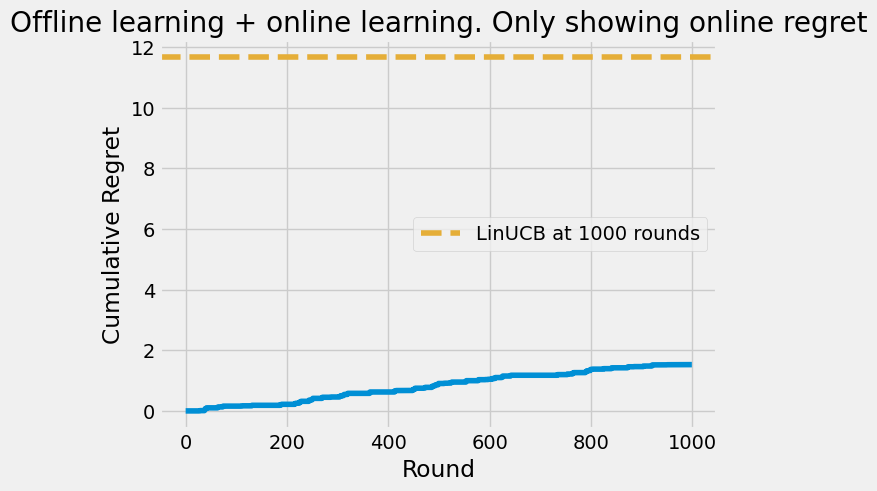

In [9]:
online_rounds = 1000
for _ in range(online_rounds):

    #Make user_age a float between -5 and 5
    user_age = np.random.uniform(-5, 5) 

    context = np.array([1.0, user_age])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    agent.update(context, oracle.rewards[-1] - true_reward_mean)


offline_plus_online_regret = np.cumsum(
    np.array(oracle.optimal_rewards[-online_rounds:]) - np.array(oracle.expected_rewards[-online_rounds:])
)


plt.plot(offline_plus_online_regret)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Offline learning + online learning. Only showing online regret")
plt.axhline(y=linucb_regret_at_1000, linestyle='--', color='#e5ae38', 
            label=f'LinUCB at 1000 rounds')
plt.legend()

The cumulative regret of the offline learning + online learning is better than the regret of the online learning alone after 1000 rounds.
However, this could be worse if we choose the wrong decay rate or if the offline data is not representative of the online data.